In [2]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/PlantVillage.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish')

finish


In [33]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/PlantVillage', 
  shuffle = True ,
  image_size = (IMAGE_SIZE,IMAGE_SIZE),
  batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [8]:
len(dataset)

68

In [9]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 0 1 1 1 0 0 1 0 2 0 0 1 0 2 2 0 1 1 1 1 1 1 0 1 0 2 0]


In [10]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch[0])

tf.Tensor(
[[[ 84.  85. 103.]
  [102. 103. 121.]
  [ 74.  75.  93.]
  ...
  [141. 146. 166.]
  [144. 149. 169.]
  [145. 150. 170.]]

 [[ 91.  92. 110.]
  [102. 103. 121.]
  [ 77.  78.  96.]
  ...
  [136. 141. 161.]
  [139. 144. 164.]
  [141. 146. 166.]]

 [[ 97.  98. 116.]
  [100. 101. 119.]
  [ 81.  82. 100.]
  ...
  [138. 143. 163.]
  [142. 147. 167.]
  [146. 151. 171.]]

 ...

 [[ 94.  95. 115.]
  [ 96.  97. 117.]
  [ 92.  93. 113.]
  ...
  [127. 132. 151.]
  [119. 124. 143.]
  [139. 144. 163.]]

 [[ 88.  89. 109.]
  [ 85.  86. 106.]
  [ 83.  84. 104.]
  ...
  [130. 135. 154.]
  [123. 128. 147.]
  [128. 133. 152.]]

 [[ 79.  80. 100.]
  [ 75.  76.  96.]
  [ 78.  79.  99.]
  ...
  [152. 157. 176.]
  [145. 150. 169.]
  [136. 141. 160.]]], shape=(256, 256, 3), dtype=float32)


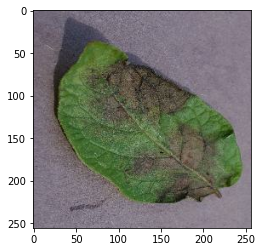

In [11]:
for image_batch , label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8')) # type flot to uint8

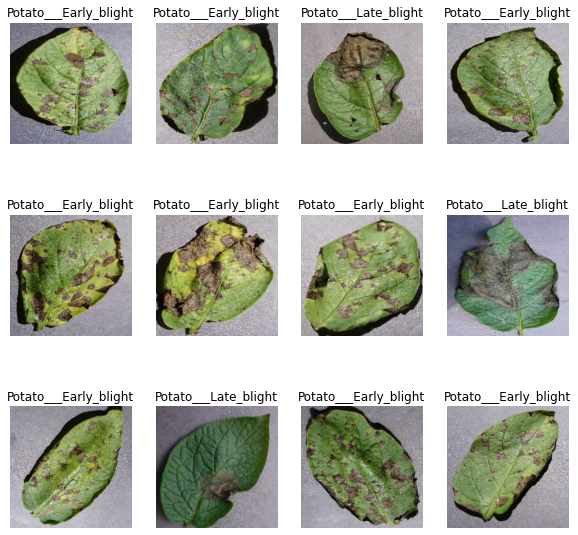

In [13]:
plt.figure(figsize=(10 , 10))
for image_batch , label_batch in dataset.take(1):
  for i in range(12):
    ax =  plt.subplot(3 , 4 ,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [14]:
train_size  = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [17]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [18]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
def get_dataset_partitions_tf(ds , train_split = 0.8 , val_split = 0.1, test_split = 0.1 , shuffle = True , shuffle_size = 10000):
  ds_size =  len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size , seed = 12)

  train_size =int(train_split * ds_size )
  val_size = int(val_split * ds_size)
  
  train_ds =ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds , val_ds , test_ds

In [21]:
train_ds , val_ds , test_ds =  get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [25]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [35]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [29]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 45s 176ms/step - loss: 0.9323 - accuracy: 0.4693 - val_loss: 0.9054 - val_accuracy: 0.4219
Epoch 2/50
54/54 [==============================] - 6s 120ms/step - loss: 0.8044 - accuracy: 0.5457 - val_loss: 0.6197 - val_accuracy: 0.7031
Epoch 3/50
54/54 [==============================] - 7s 120ms/step - loss: 0.5960 - accuracy: 0.7338 - val_loss: 0.8025 - val_accuracy: 0.5312
Epoch 4/50
54/54 [==============================] - 6s 119ms/step - loss: 0.5747 - accuracy: 0.7245 - val_loss: 0.4760 - val_accuracy: 0.8073
Epoch 5/50
54/54 [==============================] - 6s 119ms/step - loss: 0.4044 - accuracy: 0.8362 - val_loss: 0.3730 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 6s 118ms/step - loss: 0.3405 - accuracy: 0.8571 - val_loss: 0.4289 - val_accuracy: 0.8229
Epoch 7/50
54/54 [==============================] - 6s 118ms/step - loss: 0.2499 - accuracy: 0.8976 - val_loss: 0.3352 - val_accuracy: 0.8542
Epoch

In [36]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 3s 48ms/step - loss: 0.2909 - accuracy: 0.9258
Test Accuracy: 92.58%


In [37]:
scores

[0.29093316197395325, 0.92578125]

In [38]:
history

In [39]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
history.history['accuracy']

[0.46932870149612427,
 0.5457175970077515,
 0.7337962985038757,
 0.7245370149612427,
 0.8362268805503845,
 0.8570601940155029,
 0.8975694179534912,
 0.9160879850387573,
 0.953125,
 0.9207175970077515,
 0.9519675970077515,
 0.9618055820465088,
 0.9756944179534912,
 0.9380787014961243,
 0.9756944179534912,
 0.9646990895271301,
 0.9722222089767456,
 0.9797453880310059,
 0.9803240895271301,
 0.9728009104728699,
 0.9797453880310059,
 0.9849537014961243,
 0.9716435074806213,
 0.9826388955116272,
 0.984375,
 0.9901620149612427,
 0.9872685074806213,
 0.9814814925193787,
 0.9739583134651184,
 0.9895833134651184,
 0.9762731194496155,
 0.9895833134651184,
 0.9872685074806213,
 0.9866898059844971,
 0.9907407164573669,
 0.9884259104728699,
 0.9890046119689941,
 0.9930555820465088,
 0.9947916865348816,
 0.9895833134651184,
 0.9918981194496155,
 0.9907407164573669,
 0.9699074029922485,
 0.9837962985038757,
 0.9924768805503845,
 0.9913194179534912,
 0.9965277910232544,
 0.9953703880310059,
 0.99305558

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)


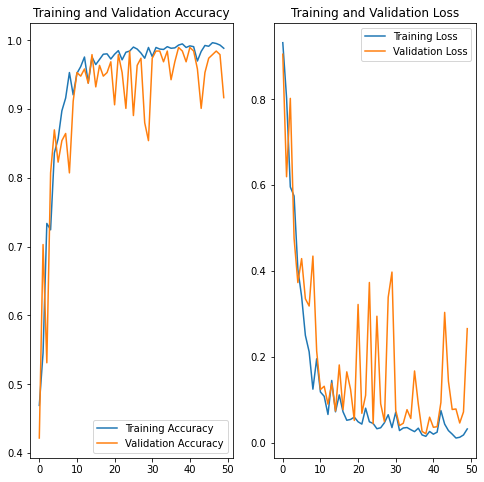

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy') 
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image  to perdict
actual label :  Potato___Late_blight
perdict image
predicted label :  Potato___Late_blight


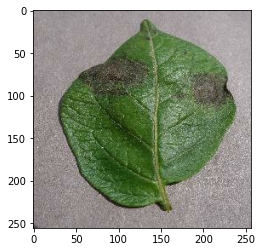

In [62]:
#plt.figure(figsize=(10 , 10))
for image_batch , label_batch in test_ds.take(1):

   first_image = image_batch[0].numpy().astype('uint8')
   first_label = label_batch[0].numpy()

   print('first image  to perdict')
   plt.imshow(first_image)
   print('actual label : ' ,class_names[first_label])
  
   print('perdict image')
   batch_prediction = model.predict(image_batch)
   print('predicted label : ' ,class_names[np.argmax(batch_prediction[0])])


In [64]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

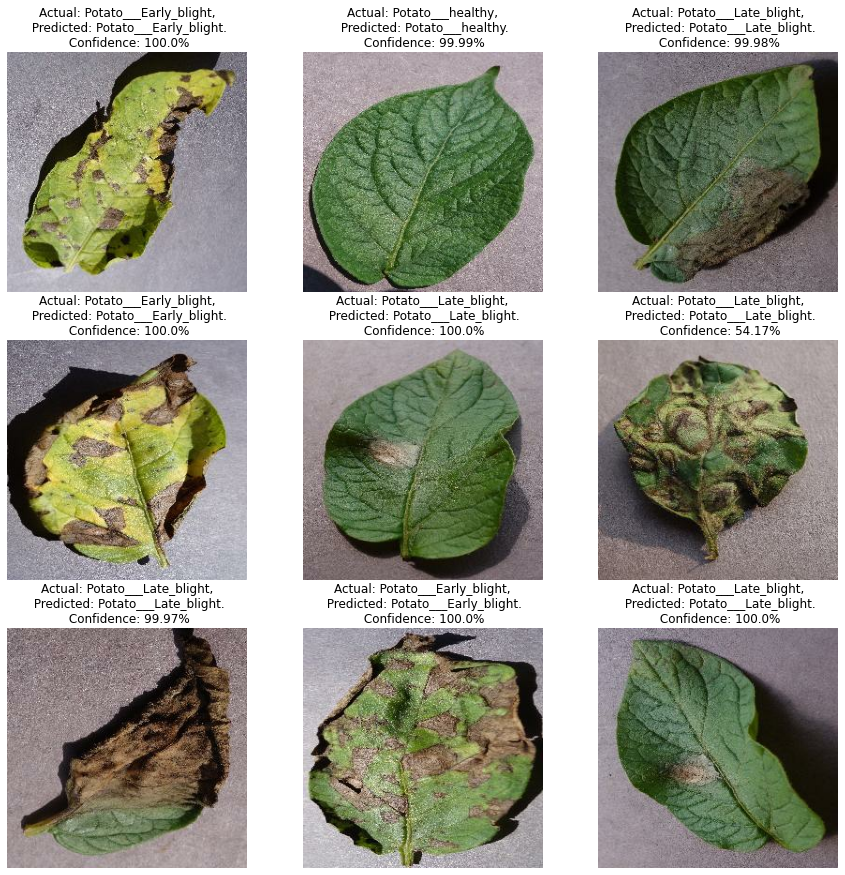

In [65]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")